# Why does sk.ensemble.RandomForestClassifier model_size grow superlinearly wrt. len(classes)?
#   - This directly affects both model size and training time (see 20180705_eval_rf_superlinear_model_size~n_species.ipynb)

In [ ]:
from notebooks import *

In [ ]:
# Plot a tree
import graphviz
rows = []
for n_species in [33, 67, 100, 134, 168]:
    model_dir = f"20180705-221102-0b94b79/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species={n_species},n_recs=3360,classifier='cls=rf,criterion=gini,n_estimators=100',random_state=0)"
    model_path = Path(data_dir) / 'artifacts' / model_dir / 'estimator.pkl'
    search = joblib.load(model_path); search
    forest = search.classifier_
    tree = forest.estimators_[0]; tree
    dirs(tree.tree_)
    rows.append(OrderedDict(dict(
        n_species=len(tree.classes_),
        nodes=tree.tree_.node_count,
        leaves=(tree.tree_.children_left == -1).sum(),
        model_size=model_path.stat().st_size,
        forest=forest,
        search=search,
    )))
    # dirs(tree.tree_)
trees = DF(rows); trees

,n_species,nodes,leaves,model_size,forest,search
0,33,363,182,14764862,"RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity...","Search(n_species=33, n_recs=3360, classifier='cls: rf, criterion: gini, n_estimators: 100', random_state=0)"
1,67,843,422,56741342,"RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity...","Search(n_species=67, n_recs=3360, classifier='cls: rf, criterion: gini, n_estimators: 100', random_state=0)"
2,100,1331,666,125368830,"RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity...","Search(n_species=100, n_recs=3360, classifier='cls: rf, criterion: gini, n_estimators: 100', random_state=0)"
3,134,1871,936,225071582,"RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity...","Search(n_species=134, n_recs=3360, classifier='cls: rf, criterion: gini, n_estimators: 100', random_state=0)"
4,168,2455,1228,357092382,"RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_features='auto', max_leaf_nodes=None,\n min_impurity...","Search(n_species=168, n_recs=3360, classifier='cls: rf, criterion: gini, n_estimators: 100', random_state=0)"


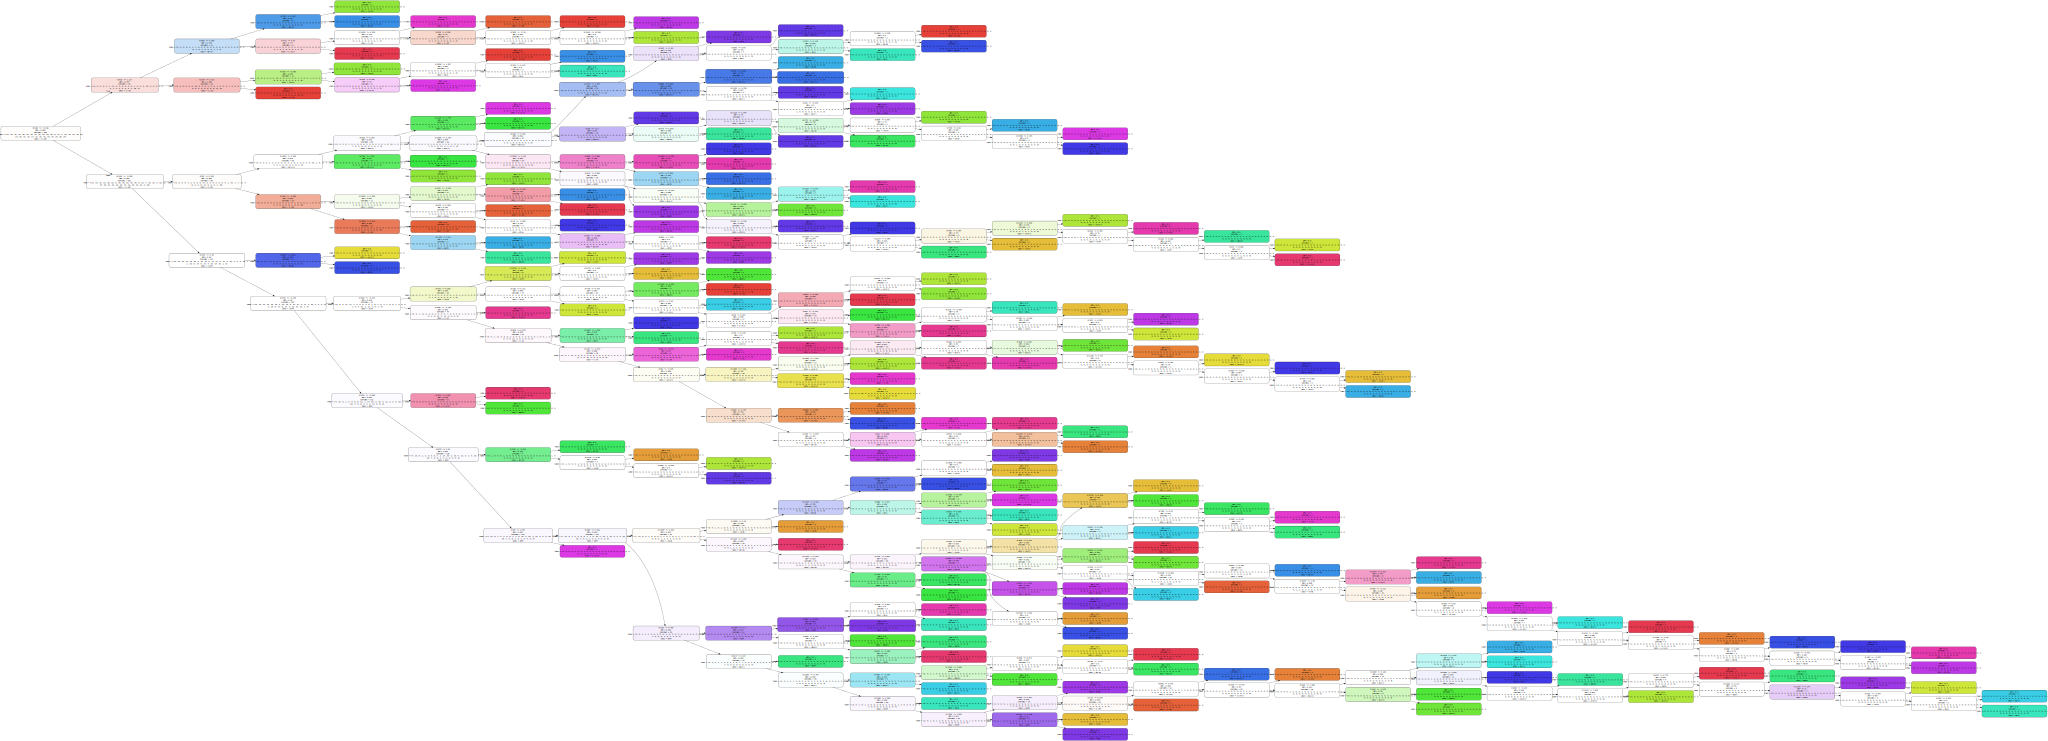

In [ ]:
graphviz.Source(sk.tree.export_graphviz(
    trees.iloc[0].forest.estimators_[0],
    out_file=None,
    class_names=search.classes_,
    filled=True,
    rotate=True,
    rounded=True,  # Better font
    # leaves_parallel=True,
))

   n_species  nodes  leaves  model_size                                                                                                                                                                                                   forest                                                                                                        search  model_size_scaled
0         33    363     182    14764862  (DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,\n            max_features='auto', max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,...   Search(n_species=33, n_recs=3360, classifier='cls: rf, criterion: gini, n_estimators: 100', random_state=0)             70.404
1         67    843     422    56741342  (DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,\n            max_features='auto', max_leaf_nodes=None,\n            min_impurity_decrease=0.0, min_impurity_split=None,...   Search(n_species=

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/stats/smoothers.py:150: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"


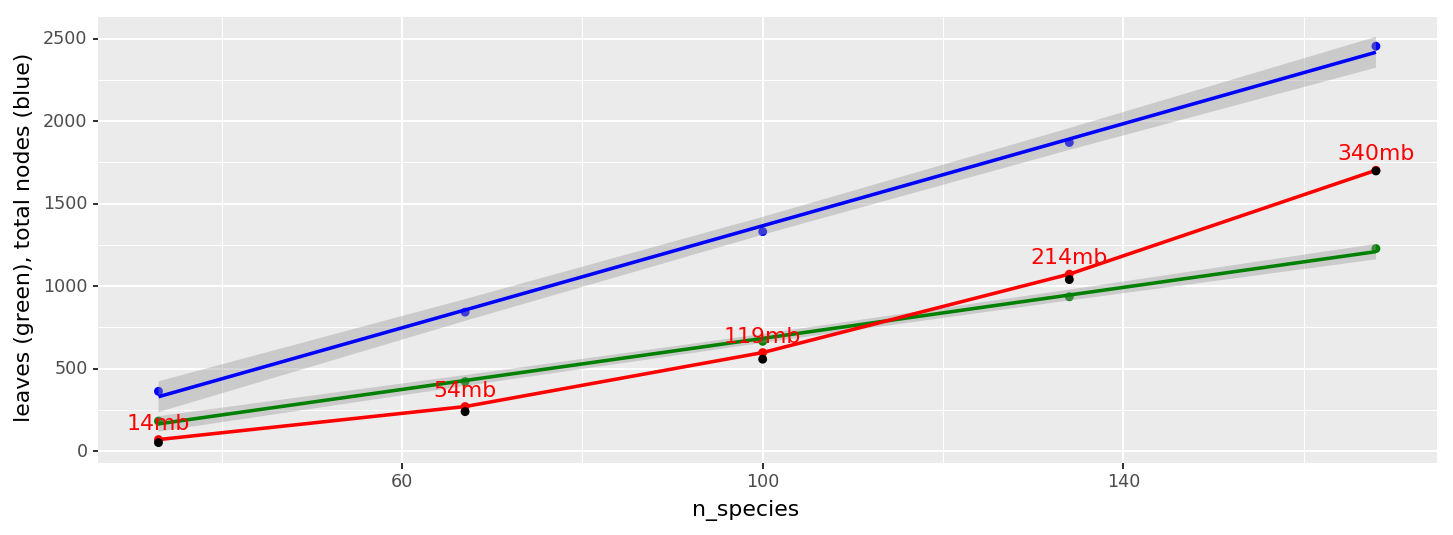

<ggplot: (-9223372036536882190)>

In [ ]:
(trees
    .assign(model_size_scaled=lambda df: df.model_size / 1024**2 * 5)
    .pipe(puts)
    .pipe(ggplot, aes(x='n_species'))
    + geom_point(aes(y='leaves'), color='green')
    + geom_point(aes(y='nodes'), color='blue')
    + geom_point(aes(y='model_size_scaled'), color='red')
    + geom_smooth(aes(y='leaves'), method='lm', color='green')
    + geom_smooth(aes(y='nodes'), method='lm', color='blue')
    + geom_smooth(aes(y='model_size_scaled'), method='lowess', color='red')
    + geom_text(aes(y='model_size_scaled', label='(model_size // 1024**2).astype(str) + "mb"'), color='red', nudge_y=100)
    + ylab('leaves (green), total nodes (blue)')
    + theme_figsize('inline_short')
    # Hypothesis: tree_size ~ n_species * nodes
    #   - TODO Why? [answer in next cell...]
    + geom_point(aes(y='(n_species * nodes) ** .985 / 200'), color='black')
)

In [ ]:
search = trees.iloc[-1].search
forest = search.classifier_
tree = forest.estimators_[0]
sizeof = lambda x: len(joblib_dumps(x))
DF(
    dict(expr=expr, value=eval(expr))
    for expr in [
        'sizeof(search)',
        'sizeof(forest)',
        'len(forest.estimators_)',
        'sizeof(tree)',
        'sizeof(tree.tree_)',
        'sizeof(tree.tree_.value)',
        # [...cont] NOTE Because Tree.value has shape (nodes, classes), which accounts for ~95% of the tree mem size!
        #   - For prediction, this isn't needed for non-leaf nodes, and for sparse classes (the common case), there's a
        #     representation that's O(~1) space (list of non-zero classes with counts) instead of Tree.value which is
        #     O(classes) space...
        #   - TODO Open an sklearn issue to ask this question and discuss this idea
        'tree.tree_.capacity',
        'tree.tree_.children_left.shape',
        'tree.tree_.children_right.shape',
        'tree.tree_.feature.shape',
        'tree.tree_.impurity.shape',
        'tree.tree_.max_depth',
        'tree.tree_.max_n_classes',
        'tree.tree_.n_classes',
        'tree.tree_.n_features',
        'tree.tree_.n_node_samples.shape',
        'tree.tree_.n_outputs',
        'tree.tree_.node_count',
        'tree.tree_.threshold.shape',
        'tree.tree_.weighted_n_node_samples.shape',
        'tree.tree_.value.shape',
    ]
)

,expr,value
0,sizeof(search),357092454
1,sizeof(forest),340917678
2,len(forest.estimators_),100
3,sizeof(tree),3439698
4,sizeof(tree.tree_),3437694
5,sizeof(tree.tree_.value),3299742
6,tree.tree_.capacity,2455
7,tree.tree_.children_left.shape,"(2455,)"
8,tree.tree_.children_right.shape,"(2455,)"
9,tree.tree_.feature.shape,"(2455,)"
